This is my solution for Kaggle <a href="https://www.kaggle.com/competitions/digit-recognizer/overview"> digit-recognizer </a> problem.

CNN-model is based on this topic: <a href="https://www.kaggle.com/competitions/digit-recognizer/discussion/426580"> Simple Keras Deep Learning Top 1% </a>.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import cv2

import os

from torch import nn
from torchvision import transforms
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm, trange

### Datasets

In [2]:
assert all(
    filename in os.listdir('data') 
    for filename in ['train.csv', 'test.csv', 'sample_submission.csv']
)

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.isna().any().any()

True

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir='data', *, dataset_type='train', k=0.8):
        self.dataset_type = dataset_type

        if dataset_type in ['train', 'val']:

            df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
            df_t, df_v = train_test_split(df, train_size=k, random_state=42)
            
            if dataset_type == 'train':
                df = df_t
            else:
                df = df_v
                
            images = df.loc[:, [f'pixel{i}' for i in range(784)]].to_numpy() / 255
            labels = df.loc[:, 'label'].to_numpy().astype(int)

            self.items = []
            for image, label in zip(images, labels):
                if not np.isnan(image).any():
                    self.items.append((image.reshape(1, 28, 28).astype(np.float32), label))

            return
            
        if dataset_type == 'test':
            
            df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
            images = df.loc[:, [f'pixel{i}' for i in range(784)]].to_numpy() / 255
            
            self.items = []
            for image in images:
                if not np.isnan(image).any():
                    self.items.append(image.reshape(1, 28, 28).astype(np.float32))
                else:
                    raise 'impossible'
                    
            return
            
        raise 'Unknown dataset_type'            

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        if self.dataset_type == 'test':
            return self.items[i]
            
        img, label = self.items[i]
        img = torch.from_numpy(img)
        label = torch.cat([torch.zeros(label), torch.ones(1), torch.zeros(9 - label)])
        
        return img, label

In [6]:
train_dataset = Dataset(dataset_type='train')
val_dataset = Dataset(dataset_type='val')
test_dataset = Dataset(dataset_type='test')

print(len(train_dataset), len(val_dataset), len(test_dataset))

22629 5658 28000


In [7]:
# test_dataset[0]

In [8]:
random_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=28, scale=(0.85, 1), antialias=True),
    transforms.RandomRotation(degrees=(-10,10))
])

def collate_fn(batch, transform=random_transform):
    imgs = []
    labels = []
    
    for img, label in batch:
        imgs.append(transform(img).reshape(1, 1, 28, 28))
        labels.append(label)

    return torch.vstack(imgs), torch.vstack(labels)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=False)

In [10]:
assert next(iter(train_loader))[0].shape == (64, 1, 28, 28)
assert next(iter(train_loader))[1].shape == (64, 10)

assert next(iter(val_loader))[0].shape == (64, 1, 28, 28)
assert next(iter(val_loader))[1].shape == (64, 10)

assert next(iter(test_loader)).shape == (64, 1, 28, 28)

### Model

In [11]:
class ConvRelu(nn.Module):
    def __init__(self, i, o, k, p, *, mp=None, do=None):
        super().__init__()

        self.layers = [nn.Conv2d(i, o, k, padding=p), nn.ReLU(), nn.BatchNorm2d(o)]
        if mp:
            self.layers.append(nn.MaxPool2d(mp))
        if do:
            self.layers.append(nn.Dropout(do))
        
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)


class Classifier(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        
        self.layers = []
        self.layers += [ConvRelu(1, h, 5, 2), ConvRelu(h, h, 5, 2, mp=2, do=0.25)]
        
        self.layers += [ConvRelu(h, h, 3, 1), ConvRelu(h, h, 3, 1, mp=2, do=0.25)]
        self.layers += [ConvRelu(h, h, 3, 1, do=0.25)]
        
        self.layers += [nn.Flatten(), nn.Linear(h * 7 * 7, 4 * h), nn.BatchNorm1d(4 * h), nn.Dropout(0.25)]
        self.layers += [nn.Linear(4 * h, 10)]
        
        self.layers = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.layers(x)

### Train

In [12]:
def new_checkpoint():
    epoch = 0
    model = Classifier()
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss = []
    train_acc = []
    val_acc = []
    
    return epoch, model, optim, train_loss, train_acc, val_acc

def save_checkpoint(epoch, model, optim, train_loss, train_acc, val_acc, *, path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optim_state_dict': optim.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,            
        }, 
        path
    )

def load_checkpoint(path):
    epoch, model, _, train_loss, train_acc, val_acc = new_checkpoint()
    
    checkpoint = torch.load(path)

    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=0.1)
    optim.load_state_dict(checkpoint['optim_state_dict'])
    
    train_loss = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    val_acc = checkpoint['val_acc']

    return epoch, model, optim, train_loss, train_acc, val_acc

def generate_checkpoint_path(dir_path='checkpoints'):
    'checkpoint_{:03}.ckpt'
    
    ld = os.listdir(dir_path)
    i = max(int(name[11:14]) for name in ld) if ld else -1
    return os.path.join(dir_path, 'checkpoint_{:03}.ckpt'.format(i + 1))

In [13]:
def acc_fn(out, labels):
    bs = labels.shape[0]
    
    labels = torch.argmax(labels, dim=1)
    out = torch.argmax(out, dim=1)
    
    assert labels.shape == out.shape
    assert out.shape[0] == bs

    return torch.sum(labels == out), bs # correct, total

def compute_acc(model, dataloader):
    with torch.no_grad():
        correct, total = 0, 0
        
        for img, label in tqdm(dataloader, leave=False):
            out = model(img.to(device)).cpu()
            
            c, t = acc_fn(out, label)
            correct += c
            total += t
            
    return correct / total
    
def train_step(batch, model, optim, loss_fn):
    img, label = batch
    
    optim.zero_grad()
                 
    out = model(img.to(device))
    loss = loss_fn(out, label.to(device))

    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), 1)
    optim.step()
    
    return loss.detach().cpu().item()

    
def train_loop(epoch, model, optim, train_loss, train_acc, val_acc, 
               train_loader, val_loader, *, epochs=10):
    
    model.to(device)
    # loss_fn = nn.MSELoss()
    loss_fn = nn.CrossEntropyLoss()
    
    loss = None
    with trange(epochs, leave=True, desc='') as pbar:
        for e in pbar:
            correct, total = 0, 0
            
            for batch in tqdm(train_loader, leave=False):
                loss = train_step(batch, model, optim, loss_fn)
                train_loss.append(loss)
                
                pbar.set_description(f'loss: {np.mean(train_loss[:-6]):.4e}')

            train_acc.append(compute_acc(model, train_loader))
            val_acc.append(compute_acc(model, val_loader))

            print('Epoch {:2}: train_acc: {:.3f}, val_acc: {:.3f}'.format(epoch, train_acc[-1], val_acc[-1]))
            
            epoch += 1
            save_checkpoint(epoch, model, optim, train_loss, train_acc, val_acc, path=generate_checkpoint_path())

In [14]:
device = torch.device('cuda')
device

device(type='cuda')

In [15]:
# epoch, model, optim, train_loss, train_acc, val_acc = new_checkpoint()

In [16]:
# train_loop(epoch, model, optim, train_loss, train_acc, val_acc, 
#            train_loader, val_loader, epochs=30)

In [17]:
# epoch, model, optim, train_loss, train_acc, val_acc = load_checkpoint('checkpoints/checkpoint_218.ckpt')
# epoch

### Results

In [18]:
epoch, model, optim, train_loss, train_acc, val_acc = load_checkpoint('checkpoints/checkpoint_272.ckpt')
epoch

30

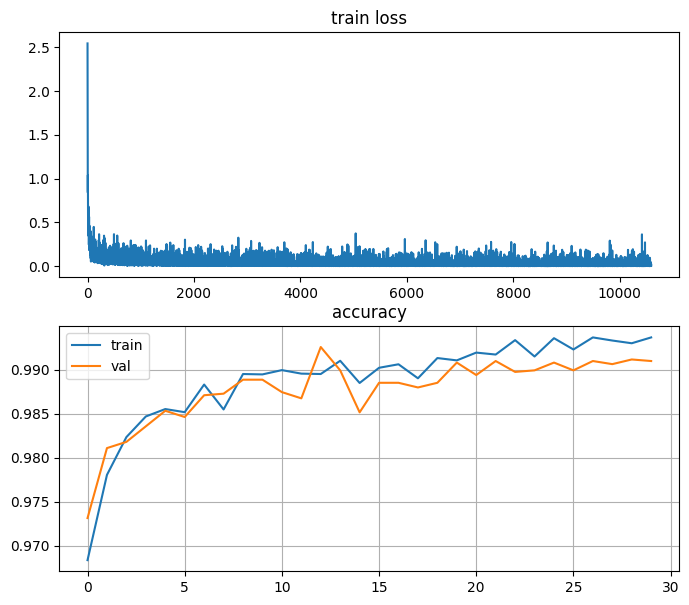

In [19]:
plt.figure(figsize=(8, 7))

plt.subplot(211)
plt.title('train loss')
plt.plot(train_loss)

plt.subplot(212)
plt.title('accuracy')

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'val'])
plt.grid(True)
plt.show()

In [20]:
print('val accuracy: {:.4f}'.format(val_acc[-1]))

val accuracy: 0.9910


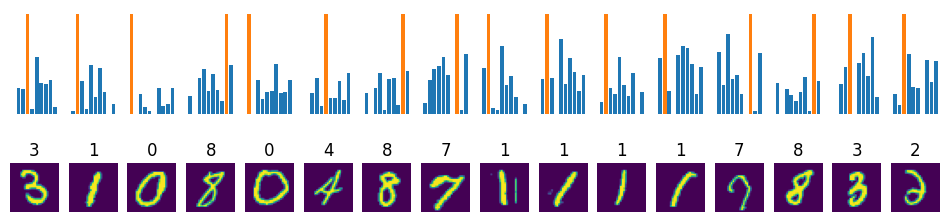

In [21]:
def draw_batch(imgs, true_labels):
    n = 16

    imgs = imgs[:n]
    true_labels = true_labels[:n]
    
    plt.figure(figsize=(12, 3))
    
    with torch.no_grad():
        labels = model(imgs.to(device)).cpu()
    
    for i, (img, label, true_label) in enumerate(zip(imgs, labels, true_labels)):
        plt.subplot(2, n, i + 1)
        plt.axis('off')

        label -= label.min()
        label /= label.max()
        true_label = torch.argmax(true_label)
        
        color = ['tab:blue'] * true_label + ['tab:orange'] + ['tab:blue'] * (9 - true_label)
        plt.bar(np.arange(10), label, color=color)

    for i, (img, label, true_label) in enumerate(zip(imgs, labels, true_labels)):
        plt.subplot(2, n, i + n + 1)
        plt.title(int(torch.argmax(label)))
        plt.axis('off')
        plt.imshow(img.reshape(28, 28))

batch = next(iter(val_loader))
draw_batch(*batch)

In [22]:
def predict(model, dataloader):
    all_outs = []
    all_true_labels = []
    
    with torch.no_grad():
        outs = []
        for batch in tqdm(dataloader):
            if type(batch) is list:
                # train or val
                imgs, true_labels = batch
                
                all_true_labels.extend(true_labels)

            else:
                # test
                imgs = batch            
            
            outs = model(imgs.to(device)).cpu()
            all_outs.extend(outs)
            
    all_outs = torch.vstack(all_outs)
    all_outs = all_outs.argmax(dim=1)

    if all_true_labels:
        all_true_labels = torch.vstack(all_true_labels)
        all_true_labels = all_true_labels.argmax(dim=1)
    
    return all_outs, all_true_labels

In [23]:
val_outs, val_true_labels = predict(model, val_loader)

val_outs.shape[0], val_true_labels.shape[0]

  0%|          | 0/89 [00:00<?, ?it/s]

(5658, 5658)

In [24]:
# !pip install seaborn

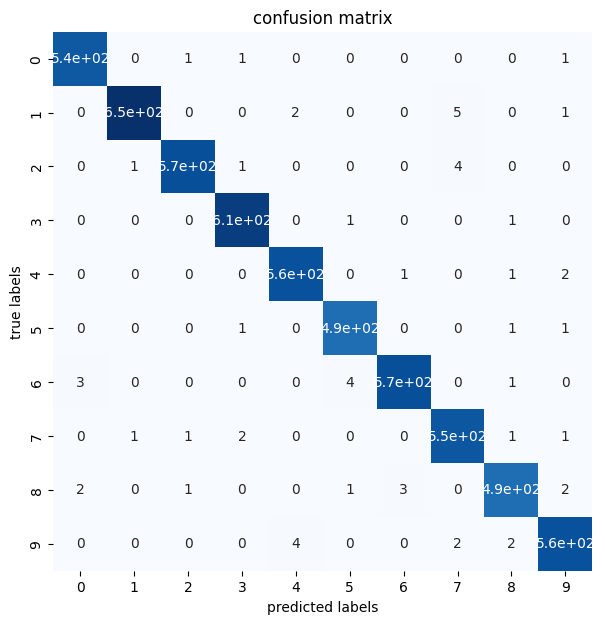

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(val_true_labels, val_outs)


plt.figure(figsize=(7, 7))
plt.title('confusion matrix')
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('predicted labels')
plt.ylabel('true labels')
plt.show()

### Generate submission

In [26]:
test_outs, _ = predict(model, test_loader)

  0%|          | 0/438 [00:00<?, ?it/s]

In [27]:
df = pd.read_csv('data/sample_submission.csv')
df.Label = test_outs

In [28]:
df.to_csv('data/submission.csv', index=False)